In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import casadi.tools as ct
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [25]:
n_y = 1
measured_state = 1 # if x1 -> 0, if x2 -> 1
use_test_set = True
import pickle as pkl
with open('data/test_set_prbs.pkl', 'rb') as f:
    test_set = pkl.load(f)
u_test = test_set['u_test']
x_n_test = test_set['x_n_test']
x_test = test_set['x_test']
y_test = test_set['y_test']
data_test = test_set['data_test']

In [26]:
def problem_data():
    """ Problem data, numeric constants,...
    """
    data = {}
    data['a'] = 0.5616
    data['b'] = 0.3126
    data['c'] = 48.43
    data['d'] = 0.507
    data['e'] = 55.0
    data['f'] = 0.1538
    data['g'] = 90.0
    data['h'] = 0.16

    data['M'] = 20.0
    data['C'] = 4.0
    #data['UA2'] = 6.84
    data['Cp'] = 0.07
    data['lam'] = 38.5
    data['lams'] = 36.6
    data['F1'] = 10.0
    data['X1'] = 5.0
    data['F3'] = 50.0
    data['T1'] = 40.0
    data['T200'] = 25.0
    return data

def intermediate_vars(x, u, data):
    """ Intermediate model variables
    """
    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = x['UA2']*(data['T3']-data['T200'])/(1.0 + x['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    return data

In [27]:
def dynamics(x, u, data):
    """ System dynamics function (discrete time)
    """
    # state derivative expression
    xdot = ca.vertcat(
        (data['F1']*data['X1'] - data['F2']*x['X2'])/data['M'],
        (data['F4'] - data['F5'])/data['C'],
        0
        )

    # create ode for integrator
    ode = {'x':x, 'p':u,'ode': xdot}

    return [ca.integrator('F','collocation',ode,{'tf':1}), ode]

def vars():
    """ System states and controls
    """
    #x = ct.struct_symMX(['X2','P2'])
    x = ct.struct_symMX(['X2','P2','UA2'])
    u = ct.struct_symMX(['P100','F200'])

    return x, u

def measurement(x, u):
    z = x
    return ca.Function('measurement', [x, u], [z])

In [28]:
# set-up system
x, u = vars()

if use_test_set:
    data = intermediate_vars(x, u, data_test[0])
else:    
    data = intermediate_vars(x, u, problem_data())
    
f = dynamics(x, u, data)[0]
h = measurement(x, u)
res = f(x0=x, p=u)

if n_y == 1:
    z = h(x, u)[measured_state]
else:
    z = h(x, u)
x_next = res['xf'] # Access x_next as the DAE symbolic solution
x_meas = measurement(x, u)
# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = ca.Function('F',[x,u],[x_next],['x','u'],['x_next'])        # nonlinear state function x(k+1) = f(x(k))
H = ca.Function('H',[x,u],[z],['x','u'],['x_meas'])     # nonlinear measurement function y(k) = g(x(k))

In [29]:
Ajacobian = ca.jacobian(F(x, u), x)
Cjacobian = ca.jacobian(H(x, u), x)
jacobian_matrix_u = ca.jacobian(F(x, u), u)
# Create a function to evaluate the Jacobian
A_linearized = ca.Function('compute_jacobian', [x, u], [Ajacobian])
#compute_jacobian_u = ca.Function('compute_jacobian_u', [x, u], [jacobian_matrix_u])
C_linearized = ca.Function('compute_jacobian', [x, u], [Cjacobian]) # assuming y1 measurable

# Define values for x and u
x_s = np.array([25.0, 49.743, 6.84])
u_s = np.array([191.713, 215.888])

# Evaluate the Jacobian at the specified values of x and u
result = C_linearized(x_s, u_s)

print("Jacobian Matrix at x =", x_s, "and u =", u_s, "is:")
print(result)

# F_partial(x_value, u_value)
# res_noisy = f_noisy(x0=x, p=u_noisy)
# x_next_noisy = res_noisy['xf']
# F_noisy = ca.Function('F_noisy',[x,u_noisy],[x_next_noisy],['x','u_noisy'],['x_next'])

Jacobian Matrix at x = [25.    49.743  6.84 ] and u = [191.713 215.888] is:
[[00, 1, 00]]


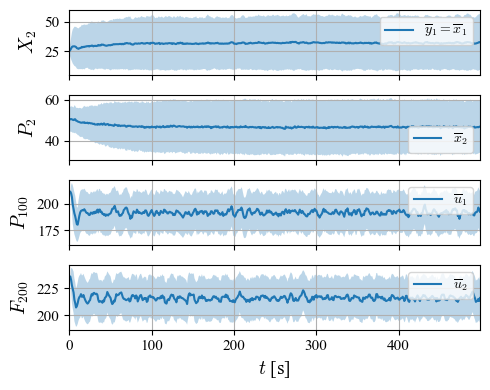

In [30]:
N = u_test.shape[0]
T = u_test.shape[1]
Ts = 1

t = np.arange(0,T,Ts)
u_mean = u_test.mean(axis=0)
u_std = u_test.std(axis=0)
y_mean = y_test.mean(axis=0)
y_std = y_test.std(axis=0)

plt.figure(figsize=(5,4))
# y1 = x1
ax1 = plt.subplot(411)
plt.plot(t, y_mean[:,0], label='$\overline{y}_1=\overline{x}_1$')
plt.fill_between(t, y_mean[:,0] - y_std[:,0], y_mean[:,0] + y_std[:,0], alpha=0.3)
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="upper right")
# x2
ax2 = plt.subplot(412, sharex=ax1)
plt.plot(t, y_mean[:,1], label='$\overline{x}_2$')
plt.fill_between(t, y_mean[:,1] - y_std[:,1], y_mean[:,1] + y_std[:,1], alpha=0.3)
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="lower right")

# y1 = x1
ax3 = plt.subplot(413)
plt.plot(t, u_mean[:,0], label='$\overline{u}_1$')
plt.fill_between(t, u_mean[:,0] - u_std[:,0], u_mean[:,0] + u_std[:,0], alpha=0.3)
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_{100}$')
plt.legend(loc="upper right")
# x2
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(t, u_mean[:,1], label='$\overline{u}_2$')
plt.fill_between(t, u_mean[:,1] - u_std[:,1], u_mean[:,1] + u_std[:,1], alpha=0.3)
plt.xlabel('$t$ [s]')
plt.ylabel(r'$F_{200}$')
plt.legend(loc="upper right")

plt.tight_layout()

In [31]:
from filterpy.kalman import ExtendedKalmanFilter

# Simulation parameters
T = 500
Ts = 1

x_0 = np.array(x_s).reshape(-1,1)
u_0 = np.array(u_s).reshape(-1,1)

# ekf part
ekf = ExtendedKalmanFilter(dim_x=3, dim_u=2, dim_z=n_y)
if use_test_set:
    #ekf.x = y_test[0,0,:].copy().reshape(-1,1)
    ekf.x = x_0.copy() + np.random.randn(3,1)
else:
    ekf.x = x_0.copy() + np.random.randn(3,1)
    
ekf.F = F # model of the dynamics (the nominal one, the real measure can be different!)

ekf.A = A_linearized

if n_y == 2:
    ekf.R = np.array([[1, 1e-6],
                      [1e-6, 1]]) # 5% of distance
else:
    ekf.R = np.array([[1]]) # 5% of distance
    
ekf.Q = np.array([[1e-1, 1e-6, 1e-6],
                  [1e-6, 1e-1, 1e-6],
                  [1e-6, 1e-6, 1e-6]])

ekf.P = np.array([[1e-6, 1e-6, 1e-6],
                  [1e-6, 1e-6, 1e-6],
                  [1e-6, 1e-6, 1e-6]])

In [32]:
import time

y = []#np.zeros((300,2))
y_noisy = []
y_hat = []# np.zeros((300,2))
P_vect = []
#eig_vect = []

# u_generated = u_s + 5*np.random.randn(300,2)
u_generated = u_test[0,:,:]

if use_test_set:
    #s = y_test[0,0,:]
    s = np.append(y_test[0,0,:], 6.84) 
else:    
    s = x_0
    s_noisy = s + np.array([[1], [2], [0]]) * np.random.randn(3,1)

time_vec = []
# this is for one test
for i in range(T):
    #print(i)
    if not use_test_set:

        y.append(s)
        y_noisy.append(s_noisy)
        y_hat.append(ekf.x)

        a = u_generated[i,:].reshape(-1,1) # action
        s_next = F(s, a)
        s_next_noisy = s_next + np.array([[2], [4], [0]]) * np.random.randn(3,1)

        if n_y == 2:
            z = s_noisy.reshape(-1,1) # measure
        else:
            z = s_noisy[measured_state]#.reshape(-1,1)
            
        s = np.array(s_next).reshape(-1,1)
        s_noisy = np.array(s_next_noisy).reshape(-1,1)
        
    else:
        
        s = np.append(y_test[0,i,:], 6.84).reshape(-1,1)
        y.append(s)
        y_hat.append(ekf.x)
        
        a = u_test[0,i,:].reshape(-1,1)        
        if n_y == 2:
            z = y_test[0,i,:].reshape(-1,1) # measure
        else:
            z = y_test[0,i,measured_state].reshape(-1,1)
        #y.append(y_test[0,i,:]) # real state value
    #y_noisy.append(s_noisy)
    #y_hat.append(ekf.x)
    P_vect.append(ekf.P)
    
    # eigen = np.linalg.eig(np.array(A_linearized(s, a)))[0]
    # 
    # eig_vect.append(eigen)
    
    
    #s_next = F(s, a)
    #s_next_noisy = s_next + np.random.randn(2,1)
    #z = s_next_noisy[1]
    #s_next_partial = h(s, a) + np.random.randn(1,1)

    # print(s_next_partial)
    # Compute partial derivative of F with respect to x1 at current time step
    #jacobian_value = compute_jacobian(s, a)
    
    # update = correzione
    start = time.time()
    ekf.update(z, C_linearized, H, args=a, hx_args=a)
    # ekf.update(s, compute_jacobian, F, args=a, hx_args=a)
    
    ekf.predict(a) # this also updates x (internally)

    time_vec.append(time.time() - start) 
    #s = np.array(s_next).reshape(-1,1) # the new measure is available
    #s_noisy = np.array(s_next_noisy).reshape(-1,1)

    #U_log = np.column_stack((U_log, a[:2]))
    #X_log = np.column_stack((X_log, x_0))
    # X_J_log_f1x1[i] = jacobian_value[0,0]  # Extract the derivative with respect to x1
    # X_J_log_f1x2[i] = jacobian_value[0,1]
    # X_J_log_f2x1[i] = jacobian_value[1,0]
    # X_J_log_f2x2[i] = jacobian_value[1,1]
    # X_J_log_f1u1[i] = jacobian_value[0,2]  # Extract the derivative with respect to x1
    # X_J_log_f1u2[i] = jacobian_value[0,3]
    # X_J_log_f2u1[i] = jacobian_value[1,2]
    # X_J_log_f2u2[i] = jacobian_value[1,3]

# plt.subplot(321)    
# plt.plot(X_log[0,:], label="$x_1$")
# plt.plot(X_log[1,:], label="$x_2$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(322)    
# plt.plot(U_log[0,:], label="$u_1$")
# plt.plot(U_log[1,:], label="$u_2$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(323)
# plt.plot(X_J_log_f1x1, label=r"$\frac{\partial f_1}{\partial x_1}$")
# plt.plot(X_J_log_f1x2, label=r"$\frac{\partial f_1}{\partial x_2}$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(324)
# plt.plot(X_J_log_f2x1, label=r"$\frac{\partial f_2}{\partial x_1}$")
# plt.plot(X_J_log_f2x2, label=r"$\frac{\partial f_2}{\partial x_2}$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(325)
# plt.plot(X_J_log_f1u1, label=r"$\frac{\partial f_1}{\partial u_1}$")
# plt.plot(X_J_log_f1u2, label=r"$\frac{\partial f_1}{\partial u_2}$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(326)
# plt.plot(X_J_log_f2u1, label=r"$\frac{\partial f_2}{\partial u_1}$")
# plt.plot(X_J_log_f2u2, label=r"$\frac{\partial f_2}{\partial u_2}$")
# plt.legend()
# plt.grid()
# 
# plt.tight_layout()
# 
# plt.savefig("../fig/jacobians_ss.pdf")

In [33]:
time_vec

[0.004004955291748047,
 0.004000425338745117,
 0.0035104751586914062,
 0.0040051937103271484,
 0.003000020980834961,
 0.005507946014404297,
 0.0075070858001708984,
 0.003999471664428711,
 0.0045621395111083984,
 0.0035686492919921875,
 0.0040018558502197266,
 0.003509044647216797,
 0.00400090217590332,
 0.0030257701873779297,
 0.004542112350463867,
 0.003973722457885742,
 0.0041811466217041016,
 0.004018545150756836,
 0.003021717071533203,
 0.0035371780395507812,
 0.004014730453491211,
 0.002996206283569336,
 0.0035860538482666016,
 0.0039980411529541016,
 0.003621816635131836,
 0.0029294490814208984,
 0.004041910171508789,
 0.003541707992553711,
 0.003042936325073242,
 0.003987789154052734,
 0.003578662872314453,
 0.00298309326171875,
 0.003000497817993164,
 0.003570556640625,
 0.004056692123413086,
 0.003951311111450195,
 0.004655361175537109,
 0.004044294357299805,
 0.004470348358154297,
 0.0029985904693603516,
 0.004001140594482422,
 0.003152608871459961,
 0.004000186920166016,
 0.

In [34]:
# plt.subplot(211)
# plt.plot(np.array(P_vect)[:,0,0], label="$P_{1,1}$")
# plt.plot(np.array(P_vect)[:,1,1], label="$P_{2,2}$")
# plt.legend()

# plt.subplot(212)
# plt.plot(np.array(eig_vect)[:,0], label="$\lambda_{1}$")
# plt.plot(np.array(eig_vect)[:,1], label="$\lambda_{2}$")
# plt.legend()

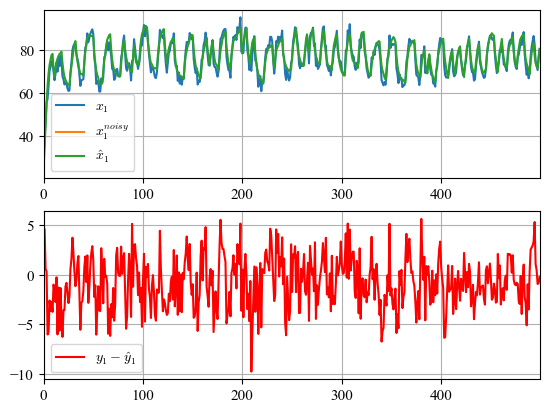

In [35]:
plt.subplot(211)
plt.plot(np.array(y).reshape(-1,3)[:,0], label='$x_1$')
plt.plot(np.array(y_noisy).reshape(-1,3)[:,0], label='$x_1^{noisy}$')
plt.plot(np.array(y_hat).reshape(-1,3)[:,0], label='$\hat{x}_1$')
plt.legend()

plt.subplot(212)
plt.plot(np.array(y).reshape(-1,3)[:,0] - np.array(y_hat).reshape(-1,3)[:,0], c='r', label='$y_1-\hat{y}_1$')
plt.legend()

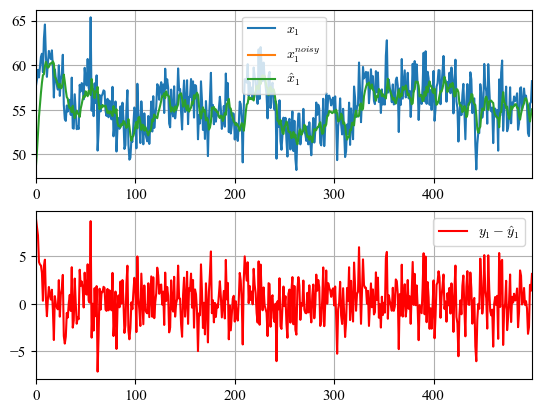

In [36]:
plt.subplot(211)
plt.plot(np.array(y).reshape(-1,3)[:,1], label='$x_1$')
plt.plot(np.array(y_noisy).reshape(-1,3)[:,1], label='$x_1^{noisy}$')
plt.plot(np.array(y_hat).reshape(-1,3)[:,1], label='$\hat{x}_1$')
plt.legend()

plt.subplot(212)
plt.plot(np.array(y).reshape(-1,3)[:,1] - np.array(y_hat).reshape(-1,3)[:,1], c='r', label='$y_1-\hat{y}_1$')
plt.legend()

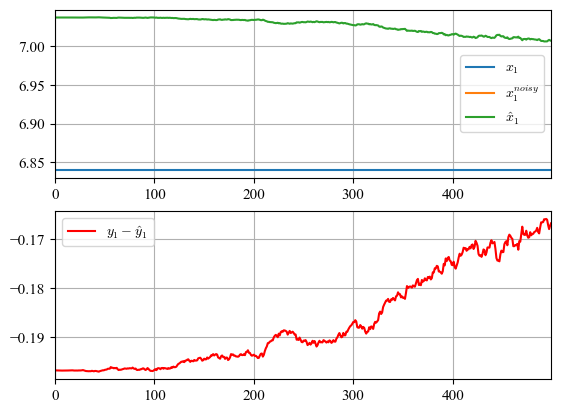

In [37]:
plt.subplot(211)
plt.plot(np.array(y).reshape(-1,3)[:,2], label='$x_1$')
plt.plot(np.array(y_noisy).reshape(-1,3)[:,2], label='$x_1^{noisy}$')
plt.plot(np.array(y_hat).reshape(-1,3)[:,2], label='$\hat{x}_1$')
plt.legend()

plt.subplot(212)
plt.plot(np.array(y).reshape(-1,3)[:,2] - np.array(y_hat).reshape(-1,3)[:,2], c='r', label='$y_1-\hat{y}_1$')
plt.legend()

In [38]:
# plt.subplot(211)
# plt.plot(np.array(y).reshape(-1,2)[:,1], label='$x_2$')
# #plt.plot(np.array(y_noisy).reshape(-1,2)[:,1], label='$x_2^{noisy}$')
# plt.plot(np.array(y_hat).reshape(-1,2)[:,1], label='$\hat{x}_2$')
# plt.legend()
# 
# plt.subplot(212)
# plt.plot(np.array(y).reshape(-1,2)[:,1] - np.array(y_hat).reshape(-1,2)[:,1], c='r', label='$y-\hat{y}$')
# plt.legend()

#plt.savefig('ekf.pdf')

In [39]:
import time

real_param_vect = []

if use_test_set:
    # Common parts
    y = np.zeros((N,T,3))
    y_hat = np.zeros((N,T,3))
    
    if n_y == 2:
        R_0 = np.array([[1, 1e-6],[1e-6, 1]]) # 5% of distance
        x_0 = x_0.copy() #+ 5 * np.random.randn(2,1)
    else:
        R_0 = np.array([[10]]) # 5% of distance
        x_0 = x_0.copy() #+ 5 * np.random.randn(2,1)
    # Q_0 = np.array([[1e3, 1e-6],[1e-6, 1e3]])
    Q_0 = np.array([[1e-6, 1e-6, 1e-6],[1e-6, 1e-6, 1e-6],[1e-6, 1e-6, 1e-6]])
    P_0 = np.array([[1e-6, 1e-6, 1e-6],[1e-6, 1e-6, 1e-6],[1e-6, 1e-6, 1]])
    
    # Complete cycle
    #start = time.time()
    
    time_vec = []
    
    for n in range(0,N):
        
        print(n)
        
        # create the model for each system
        # print(data_test[n].keys())
        real_UA2 = data_test[n].pop('UA2')
        real_param_vect.append(real_UA2)
        
        data = intermediate_vars(x, u, data_test[n])
        
        #data = intermediate_vars(x, u, problem_data())
        f = dynamics(x, u, data)[0]
        h = measurement(x, u)
        res = f(x0=x, p=u)
        if n_y == 1:
            z = h(x, u)[measured_state]
        else:
            z = h(x, u)
        x_next = res['xf'] # Access x_next as the DAE symbolic solution
        x_meas = measurement(x, u)
        
        # Define function F to simplify mapping between symbolic (x,u) --> (x_next)
        F = ca.Function('F',[x,u],[x_next],['x','u'],['x_next'])        # nonlinear state function x(k+1) = f(x(k))
        H = ca.Function('H',[x,u],[z],['x','u'],['x_meas'])     # nonlinear measurement function y(k) = g(x(k))
        
        Ajacobian = ca.jacobian(F(x, u), x)
        Cjacobian = ca.jacobian(H(x, u), x)
        
        # Create a function to evaluate the Jacobian
        A_linearized = ca.Function('compute_jacobian', [x, u], [Ajacobian])
        C_linearized = ca.Function('compute_jacobian', [x, u], [Cjacobian]) # assuming y1 measurable

        
        # Filter for each system
        ekf = ExtendedKalmanFilter(dim_x=3, dim_u=2, dim_z=n_y)
        #ekf.x = x_0
        ekf.F = F # model of the dynamics (the nominal one, the real measure can be different!)
        ekf.A = A_linearized
        ekf.R = R_0
        ekf.Q = Q_0
        ekf.P = P_0
        
        ekf.x = np.append(y_test[n,0,:], 6.84).reshape(-1,1)
        
        u_generated = u_test[n,:,:]        
        
        for i in range(T):
            
            s = np.append(y_test[n,i,:], real_UA2).reshape(-1,1)# + np.array([[2], [4]]) * np.random.randn(2,1)  # current state with process noise
            y[n,i,:] = s.flatten()                      # update real measure
            y_hat[n,i,:] = ekf.x.flatten()              # compare with ekf estimate
            
            a = u_generated[i,:].reshape(-1,1)        # action at time t
            
            if n_y == 2:
                z = y_test[n,i,:].reshape(-1,1) # measure
            else:
                z = y_test[n,i,measured_state].reshape(-1,1)# + np.array([[4]]) * np.random.randn(1,1)
                
            start = time.time()
            
            ekf.update(z, C_linearized, H, args=a, hx_args=a)    # this updates the ekf
            ekf.predict(a)                                       # this also updates x (internally)
       
            time_vec.append(time.time() - start)     
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [44]:
np.reshape(time_vec, (u_test.shape[0], u_test.shape[1]))

array([[0.0045104 , 0.00399828, 0.00350451, ..., 0.00362921, 0.00395918,
        0.00299358],
       [0.00366449, 0.00350285, 0.00300813, ..., 0.00360322, 0.00351429,
        0.00300026],
       [0.00399709, 0.00299931, 0.00451183, ..., 0.00299692, 0.00358486,
        0.00399971],
       ...,
       [0.00404119, 0.00396347, 0.00350904, ..., 0.00393248, 0.0029912 ,
        0.00354123],
       [0.00399852, 0.00351596, 0.00300026, ..., 0.00400758, 0.004035  ,
        0.00355434],
       [0.00357795, 0.00400448, 0.00399971, ..., 0.00399208, 0.00354075,
        0.0030098 ]])

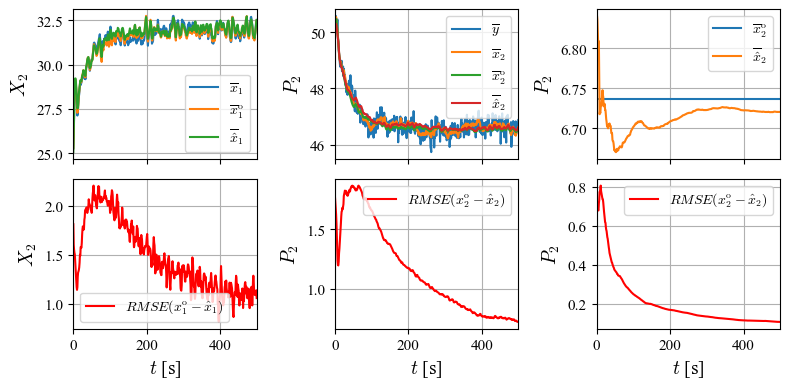

In [45]:
x1_n_mean = x_n_test[:,:,0].mean(axis=0)
x1_mean = x_test[:,:,0].mean(axis=0)
x1_hat_mean = y_hat[:,:,0].mean(axis=0)
x1_err_mean = np.sqrt(np.power(x_n_test[:,:,0] - y_hat[:,:,0], 2).mean(axis=0))
x2_n_mean = x_n_test[:,:,1].mean(axis=0)
x2_mean = x_test[:,:,1].mean(axis=0)
x2_hat_mean = y_hat[:,:,1].mean(axis=0)
x2_err_mean = np.sqrt(np.power(x_n_test[:,:,1] - y_hat[:,:,1], 2).mean(axis=0))
y2_mean = y_test[:,:,1].mean(axis=0)
x3_n_mean = (np.array(real_param_vect).reshape(-1,1) * np.ones(x_n_test[:,:,0].shape)).mean(axis=0)
x3_hat_mean = y_hat[:,:,2].mean(axis=0)
x3_err_mean = np.sqrt(np.power((np.array(real_param_vect).reshape(-1,1) * np.ones(x_n_test[:,:,0].shape)) - y_hat[:,:,2], 2).mean(axis=0))

fig = plt.figure(figsize=(8,4))

ax1 = plt.subplot(231)
plt.plot(t, x1_mean, label='$\overline{x}_1$')
plt.plot(t, x1_n_mean, label='$\overline{x}^{\mathrm{o}}_1$')
plt.plot(t, x1_hat_mean, label='$\overline{\hat{x}}_1$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="lower right")

ax2 = plt.subplot(234, sharex=ax1)
plt.plot(x1_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_1 - \hat{x}_1)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$')
plt.legend()

ax3 = plt.subplot(232)
plt.plot(t, y2_mean, label='$\overline{y}$')
plt.plot(t, x2_mean, label='$\overline{x}_2$')
plt.plot(t, x2_n_mean, label='$\overline{x}^{\mathrm{o}}_2$')
plt.plot(t, x2_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax4 = plt.subplot(235, sharex=ax1)
plt.plot(x2_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.legend()

ax5 = plt.subplot(233)
plt.plot(t, x3_n_mean, label='$\overline{x}^{\mathrm{o}}_2$')
plt.plot(t, x3_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax6 = plt.subplot(236, sharex=ax1)
plt.plot(x3_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.legend()

plt.tight_layout()
plt.savefig('ekf_unknown_param2.pdf')
plt.show()

In [47]:
ekf_data = {'t':t,
            'u1':u_test[:,:,0],
            'u2':u_test[:,:,1],
            'x1_n':x_n_test[:,:,0],
            'x2_n':x_n_test[:,:,1],
            'x1':x_test[:,:,0],
            'x2':x_test[:,:,1],
            'y1':y_test[:,:,0],
            'y2':y_test[:,:,1],
            'x1_hat':y_hat[:,:,0],
            'x2_hat':y_hat[:,:,1],
            'time':np.reshape(time_vec, (u_test.shape[0], u_test.shape[1]))
            }

In [48]:
with open("data/ekf_prbs_unknown_param_data.pkl", "wb") as f:
    pkl.dump(ekf_data, f)

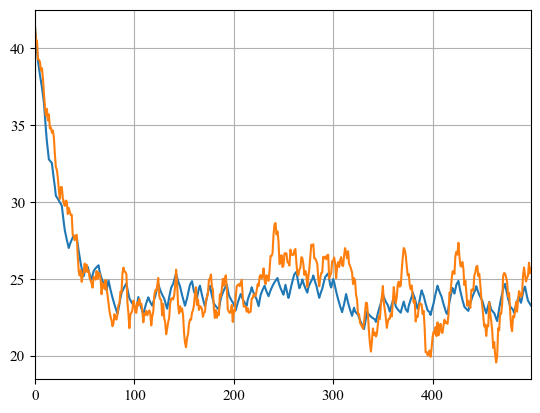

In [106]:
plt.plot(x_n_test[2,:,1]) 
plt.plot(x_test[2,:,1])